# Carls' Implementation of QAOA

References:

https://qiskit.org/textbook/ch-applications/qaoa.html

In [4]:
!pip3 install qiskit
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram


from scipy.optimize import minimize

!pip3 install pytket-qiskit
!pip3 install pytket
import pytket
from pytket.extensions.quantinuum import QuantinuumBackend

from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter

## Connecting with Quantinuum H1-2E Machine

In [5]:
machine = 'H1-2E'
backend = QuantinuumBackend(device_name=machine)
backend.login()
print(machine, "status: ", backend.device_state(device_name=machine))

Enter your Quantinuum email:  elchun@mit.edu
Enter your Quantinuum password:  ········


H1-2E status:  online


## Create QUBO Instance

We first create an instance of a Quadratic Unconstrained Binary Optimization problem.

In this example, we solve the Max-Cut problem

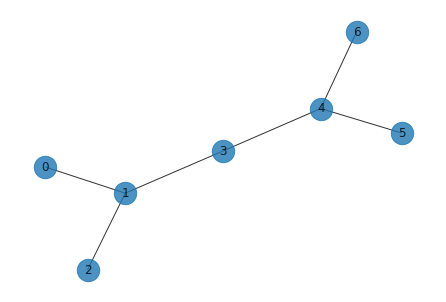

In [7]:
n_qubits = 7
p = 1
shots = 1000
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3,4,5])
# G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (3, 4), (4,5), (4,6)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

## Convert to Quantum Circuit

### Create Mixing Quantum Circuit

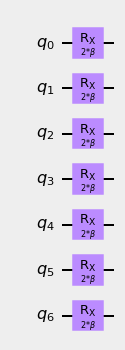

In [8]:
def create_mixing_qc(n_qubits, beta):
    qc_mix = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix

qc = create_mixing_qc(n_qubits, Parameter("$\\beta$"))

circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})

        

### Create Problem Quantum Circuit

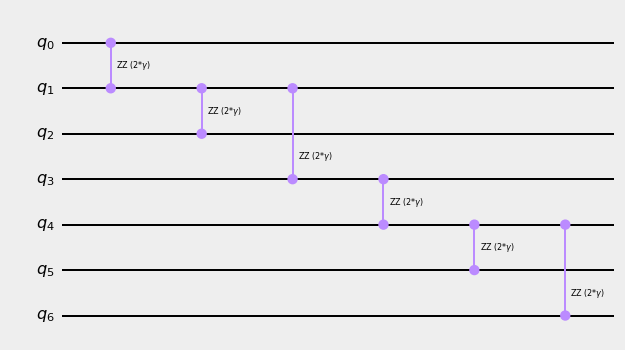

In [9]:
def create_graph_problem_qc(G, n_qubits, gamma):
    qc_p = QuantumCircuit(n_qubits)
    for pair in list(G.edges()):  # pairs of nodes
        qc_p.rzz(2 * gamma, pair[0], pair[1])
        # qc_p.barrier()
    return qc_p

qc = create_graph_problem_qc(G, n_qubits, Parameter("$\\gamma$"))
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create Initial State

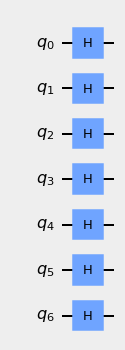

In [10]:
def create_initial_qc(n_qubits):
    qc_0 = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_0.h(i)
    return qc_0

qc = create_initial_qc(n_qubits)
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Combine into QAOA Circuit

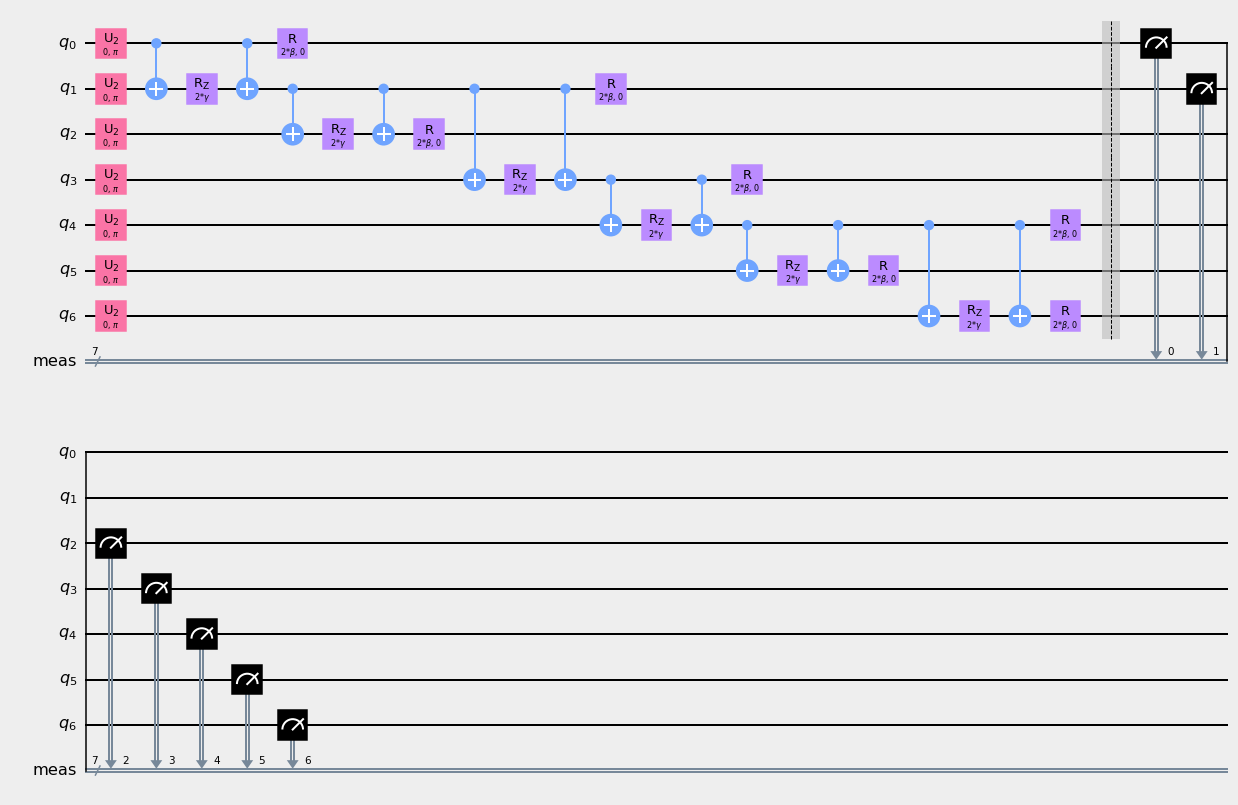

In [11]:
def create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator, 
                     beta_list, gamma_list):
    qc = QuantumCircuit(n_qubits)
    
    # Add initial state and specify which qubits to attach
    attach_qubits = [i for i in range(0, n_qubits)]
    qc.append(create_initial_qc(n_qubits), attach_qubits[:])
    
    assert len(beta_list) == len(gamma_list), 'Beta and gamma list must \
        be the same length'
    n_reps = len(beta_list)
    
    # Now add repeated applications of problem and mixing circuits
    for rep in range(0, n_reps):
        qc.append(problem_qc_generator(n_qubits, gamma_list[rep]), attach_qubits[:])
        qc.append(mixing_qc_generator(n_qubits, beta_list[rep]), attach_qubits[:])
    
    qc.measure_all()
    return qc

beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")
beta_list = [beta for _ in range(p)]
gamma_list = [gamma for _ in range(p)]

# Define wrappers for problem qc and mixing qc generator.
# This allows us to solve a variety of QUBO problems with the same stack.
def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)


qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                      beta_list, gamma_list)

# Decompose to show individual elements, then draw
circuit_drawer(qc.decompose().decompose(), output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create helper method to calculate expection

In [27]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


# def compute_expectation(counts, G):
    
#     """
#     Computes expectation value based on measurement results
    
#     Args:
#         counts: dict
#                 key as bitstring, val as count
           
#         G: networkx graph
        
#     Returns:
#         avg: float
#              expectation value
#     """
    
#     avg = 0
#     sum_count = 0
#     for bitstring, count in counts.items():
        
#         obj = maxcut_obj(str(bitstring[::-1]), G)
#         avg += obj * count
#         sum_count += count
        
#     return avg/sum_count

def compute_expectation_tket(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

    


def get_expectation(problem_qc_generator, mixing_qc_generator, n_qubits, shots=1028):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    # backend = Aer.get_backend('qasm_simulator')
    
    def execute_circ(theta):
        midpt = len(theta) // 2
        beta_list = theta[:midpt]
        gamma_list = theta[midpt:]
        
        qc = create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator,
                          beta_list, gamma_list)
        
        tk_qc = qiskit_to_tk(qc)
        tk_qc.measure_all()
        # There are three levels of optimization (we set to 1 for now)
        compiled_qc = backend.get_compiled_circuit(tk_qc, optimisation_level=1)
        
        handle = backend.process_circuit(compiled_qc, n_shots=shots)
        print('handle: ', handle)
        status = backend.circuit_status(handle)
        print('status: \n', status)
        
        results = backend.get_result(handle)
        counts = results.get_counts()
        
        # # Have to decompose in order to run backend
        # counts = backend.run(qc.decompose().decompose(), seed_simulator=10, 
        #                      shots=shots).result().get_counts()

        return compute_expectation_tket(counts, G)
    
    return execute_circ

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

# This returns a function which can optimize classically
get_expectation(graph_qc_generator, mixing_qc_generator, n_qubits, shots)


<function __main__.get_expectation.<locals>.execute_circ(theta)>

### Run QAOA

In [28]:
def qaoa(problem_qc_generator, mixing_qc_generator, n_qubits, shots):
    
    expectation = get_expectation(problem_qc_generator, mixing_qc_generator, 
                                  n_qubits, shots)

    initial_theta_value = [1.0 for _ in range(p * 2)]
    res = minimize(expectation, 
                   initial_theta_value,
                   method='COBYLA',
                   tol=0.001) 
    
    return res
    
res = qaoa(graph_qc_generator, mixing_qc_generator, n_qubits, shots)
print(res)
print(res.x)  # [ 1.357e+00  1.125e+00]

handle:  ('30934e86242a44bc989ffce11d5e9287', 'null')
status: 
 CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "circuit-352", "submit-date": "2023-01-29T07:34:04.646716", "result-date": null, "queue-position": null, "cost": null, "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
handle:  ('3e3deff47ab5421da71a435052918beb', 'null')
status: 
 CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "circuit-362", "submit-date": "2023-01-29T07:34:25.944925", "result-date": null, "queue-position": null, "cost": null, "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
handle:  ('c915397aa1354150b5006d7785b0bb75', 'null')
status: 
 CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queue

In [2]:
# sim_backend = Aer.get_backend('aer_simulator')
res_shots = shots

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

beta, gamma = res.x[:p], res.x[p:]

qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                          beta, gamma)

tk_qc = qiskit_to_tk(qc)
tk_qc.measure_all()
compiled_qc = backend.get_compiled_circuit(tk_qc, optimisation_level=1)
handle = backend.process_circuit(compiled_qc, n_shots=res_shots)
status = backend.circuit_status(handle)
print('handle: ', handle)
print('status: \n', status)

results = backend.get_result(handle)
counts = results.get_counts()

# counts = sim_backend.run(qc.decompose().decompose(), seed_simulator=10, shots=10000).result().get_counts()


# Print out bitstring

print(counts)
s = []
max_val = 0
for _ in counts.values():
    s.append(_)

s.sort()
viz = s[-2:]
for k, v in counts.items():
    if v in viz:
        print(k[::-1])

print(sum(s))

plot_histogram({str(k): v for k, v in counts.items()})

NameError: name 'shots' is not defined